In [595]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [617]:
DIM = 15*9 + 3 # with 2nd-order term, hour, day and bias

class Dataset:
    def __init__(self):
        self.X = None
        self.X_t = None
        self.y_hat = None
        self.df = None
        self.w = None
    def normalize(self):
        mean_x = np.nanmean(self.X, axis=1)
        std_x = np.nanstd(self.X, axis=1)
        std_x[std_x == 0] = 1
        self.X = (self.X - mean_x[:, np.newaxis]) / std_x[:, np.newaxis]
        self.X_t = self.X.T
        
trainset = Dataset()
trainset.df = pd.read_csv('train_datas_0.csv', dtype='float', na_values='-')
trainset.df1 = pd.read_csv('train_datas_1.csv').apply(pd.to_numeric, errors='coerce')

testset = Dataset()
testset.df = pd.read_csv('test_datas.csv', dtype='float', na_values='-')

In [618]:
def preprocess_training_data():
    # correct dataframe
    trainset.df1.drop(trainset.df1.index[-2+2162:-2+2208], inplace=True)
    trainset.df1.dropna(how='all', inplace=True)
    trainset.df1.drop(trainset.df1.index[(trainset.df1 == 0).all(axis=1)], inplace=True)
    for s in (trainset.df, trainset.df1, testset.df):
        for cnam in s.columns:
            # fill NaN with mean
            s[cnam].fillna(s[cnam].mean(), inplace=True)

            # replace outlier with mean
            # TODO: inplace?
            s[cnam][abs(s[cnam] - s[cnam].mean()) > 10 * s[cnam].std()] = s[cnam].mean()

        s.reindex()

    # extract feature
    d = DIM
    n = len(trainset.df) - 9 + len(trainset.df1) - 9
    X = np.zeros((d, n))
    y_hat = np.zeros(n)
    
    for i in range(len(trainset.df)-9):
        X[0:15*9, i] = trainset.df.iloc[i:i+9].to_numpy().flatten()
        X[15*9, i] = i % 24 # hour
        X[15*9+1, i] = (i // 24) % 365 # day
        X[15*9+2, i] = 1 # bias
        y_hat[i] = trainset.df.iloc[i+9]['PM2.5']
    
    off = len(trainset.df) - 9
    for i in range(len(trainset.df1)-9):
        X[0:15*9, i+off] = trainset.df1.iloc[i:i+9].to_numpy().flatten()
        X[15*9, i+off] = i % 24 # hour
        X[15*9+1, i+off] = (i // 24) % 365 # day
        X[15*9+2, i+off] = 1 # bias
        y_hat[i] = trainset.df1.iloc[i+9]['PM2.5']

    trainset.X = X
    trainset.X_t = X.T
    trainset.y_hat = y_hat
    #trainset.normalize()

preprocess_training_data()

In [620]:
np.savetxt('a.csv', trainset.X_t, fmt='%.2f', delimiter=',')
# c = trainset.df1['SO2']
# std_c = c.std()
# mean_c = c.mean()
# c[abs(c - mean_c) > 3 * std_c]

pd.options.display.max_rows = None
#trainset.X[:,8753-2+2154:8753-2+2300]
#trainset.df1.iloc[2534:2550]
#trainset.df1[trainset.df1.isnull().any(axis=1)]
#trainset.df1.iloc[7518:7800]

In [599]:
def train(X, y_hat, lr, reg, num_iter, b1, b2):
    # training
    print('lr',lr,'reg',reg,'num_iter',num_iter,'b1',b1,'b2',b2)
    
    X_t = X.T
    d, n = X.shape
    w = np.zeros(d)
    m = np.zeros(d) # momentum
    v = 0 # avg. sq. of past grad.
    loss = np.zeros(num_iter)
    for i in range(num_iter):
        # L(w) = ‖ Xᵀ - ŷ ‖² + reg * ‖w‖²
        # ∇L(w) = 2 * X * (Xᵀ * w - ŷ) + 2 * reg * w
        y = np.dot(X_t, w)
        loss[i] = np.inner(y - y_hat, y - y_hat) + reg * np.linalg.norm(w, 1)
        grad = np.dot(X, y - y_hat) + reg * w
        
        # Adagrad
        #v += np.inner(grad, grad)
        #w = w - lr / np.sqrt(v) * grad
        
        # Momentum
        m = b1 * m - lr * grad
        w = w + m
        
        # Adam
        #m = b1 * m + (1-b1) * grad
        #v = b2 * v + (1-b2) * np.inner(grad, grad)
        #w = w - lr * (m / (1-b1)) / (np.sqrt(v / (1-b2)) + 1e-10)
        
        if i == num_iter-1:
            #print('i',i)
            #print('std_x',std_x)
            #print('rr',rr)
            #print('Xt',X_t)
            print('y', y)
            print('y_hat', y_hat)
            #print('grad', grad)
            print('w', w)
            print('loss', loss[i])
    plt.plot(loss)
    return w

In [600]:
def validate(X, y_hat, w):
    # validate
    X_t = X.T
    y = np.dot(X_t, w)
    return np.inner(y - y_hat, y - y_hat)

lr 1e-10 reg 0 num_iter 1000 b1 0.98 b2 0.9
y [23.87 23.2  20.29 ... 11.28  9.57  9.39]
y_hat [21. 14. 11. ...  0.  0.  0.]
w [ 0.21 -0.01  0.    0.03  0.04  0.   -0.02  0.   -0.02 -0.11  0.18  0.05
 -0.    0.04  0.01  0.21 -0.01 -0.    0.01  0.04 -0.01 -0.02  0.   -0.02
 -0.08  0.14  0.05 -0.    0.04 -0.01  0.2  -0.01 -0.    0.02  0.04  0.
 -0.02  0.   -0.02 -0.07  0.1   0.05 -0.    0.04 -0.    0.2  -0.01 -0.01
  0.02  0.03 -0.   -0.02  0.   -0.02 -0.06  0.09  0.06 -0.    0.03 -0.
  0.2  -0.01 -0.    0.03  0.03 -0.   -0.02  0.   -0.02 -0.05  0.08  0.06
 -0.    0.03 -0.01  0.2  -0.02 -0.    0.03  0.03  0.   -0.02  0.   -0.02
 -0.05  0.08  0.06 -0.    0.02 -0.02  0.2  -0.01  0.    0.03  0.03  0.
 -0.02  0.   -0.02 -0.06  0.1   0.06 -0.    0.02 -0.01  0.21 -0.01  0.
  0.03  0.03  0.   -0.02  0.   -0.02 -0.08  0.12  0.06 -0.    0.02 -0.01
  0.21 -0.02  0.02  0.05  0.03  0.02 -0.02  0.   -0.02 -0.08  0.18  0.06
 -0.    0.01 -0.01  0.06  0.03  0.02]
loss 2359821.990162039


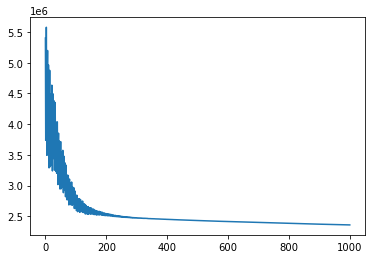

In [601]:
def run():
    X = trainset.X
    y_hat = trainset.y_hat
    d, n = X.shape
    
    lr = 1e-10 # learning rate
    reg = 0 # regularization term, lasso or ridge
    validate_sz = 2000
    num_iter = 1000
    b1 = 0.98
    b2 = 0.9
  
    testset.w = train(X, y_hat, lr, reg, num_iter, b1, b2)

#     loss = []
#     for i in range(0, n, validate_sz):
#         idx_validate = pd.Series([False] * n)
#         idx_validate[i:i+validate_sz] = True

#         testset.w = train(X[:, ~idx_validate], y_hat[~idx_validate], lr, reg, num_iter, b1, b2)
#         loss.append(validate(X[:, idx_validate], y_hat[idx_validate], testset.w))

#     print('validate loss', np.mean(loss))
#     print()

run()

#np.set_printoptions(threshold=1e3, suppress=True, precision=2)
#d,n=trainset.X.shape
#np.concatenate((trainset.X.T.dot(testset.w), trainset.y_hat)).reshape((n,2))
#np.vstack(trainset.X.T.dot(testset.w) - trainset.y_hat)

In [602]:
def preprocess_testing_data():
    d = DIM
    n = (len(testset.df) + 8) // 9
    X = np.zeros((d, n))

    # extract feature
    for i in range(n):
        X[0:15*9, i] = testset.df.iloc[i*9:(i+1)*9].to_numpy().flatten()
        X[15*9, i] = i % 24 # hour
        X[15*9+1, i] = (i // 24) % 365 # day
        X[15*9+2, i] = 1 # bias
    testset.X = X
    testset.X_t = X.T

    #testset.normalize()

preprocess_testing_data()

In [603]:
def predict():
    y_pred = np.dot(testset.X_t, testset.w).round(0).astype(int)
    return y_pred
y_pred = predict()
y_pred

array([ -1,   2,  -1,   5,  -3,   1,  13,  11,  15,   7,   5,   3,   6,
         7,   3,   9,   5,   2,  -2,   2,  -1,  -3,  -5,  -1,  -2,  -1,
        -3,   0,  -1,   0,  -2,  -1,  -2,  -2,  -3,   2,   1,   1,  -5,
         0,   0,  -1,   0,   1,   4,   2,   2,   3,   3,   4,   9,   4,
         2,   8,   3,   1,   5,  -2,  -3,  -4,  -4,  -2,  -4,  -2,  -2,
        -1,  -3,   1,   3,   8,   1,   5,   3,   2,   7,   4,   0,  -2,
        -5,  -1,  -1,   0,   0,  -1,  -2,  -2,  -8,  -2,  -3,   1,  -3,
         0,   1,   1,  -1,   0,  -3,  -1,  -6,  -3,   9,   5,  -1,  -3,
         0,   1,   0,  -3,  -6,  -6,  -3,  -6,   0,   1,  -3,  -3,  -2,
        -5,  -1,  -6,  -6,  -8,  -8,   0,   0,   0,  -5, -14,  -6,  -9,
        -1,  -4,  -2,  -5,  -2,   1,  -7,  -2,  -7,  -5,   1,  11,   6,
         5,   0,   2,   5,   1,   7,  11,  -1,   0,  -3,   0,  -1,  -4,
        -2,   4,   2,  -4,  -8, -13,  -6,  -2,   1,   1,   2,  -3,  -2,
        -6,   1,  -2,  -5,   1,  -1,  -5,  -5,  -6,   1,  -1,  -

In [604]:
pred_df = pd.DataFrame({
    'id': ['id_' + str(i) for i in range(500)],
    'value': y_pred
})
pred_df.to_csv('submission.csv', index=False)

In [605]:
def closed_form_solution():
    w_hat, residuals, rank, s  = np.linalg.lstsq(trainset.X_t, trainset.y_hat)
    #print(residuals, rank, s)
    X = trainset.X
    X_t = trainset.X_t
    y_hat = trainset.y_hat
    assert w_hat.shape[0] == DIM
    print('w',testset.w)
    print('w_hat',w_hat)
    print('train loss', np.linalg.norm(trainset.X_t.dot(w_hat) - trainset.y_hat)**2)
    
    print('test predict', np.dot(testset.X_t, w_hat).round(0).astype(int))
    
    loss = []
    d, n = trainset.X.shape
    validate_sz = 2000
    for i in range(0, n, validate_sz):
        idx_validate = pd.Series([False] * n)
        idx_validate[i:i+validate_sz] = True
        loss.append(validate(X[:, idx_validate], y_hat[idx_validate], testset.w))
    print('validation loss', np.mean(loss))

closed_form_solution()

w [ 0.21 -0.01  0.    0.03  0.04  0.   -0.02  0.   -0.02 -0.11  0.18  0.05
 -0.    0.04  0.01  0.21 -0.01 -0.    0.01  0.04 -0.01 -0.02  0.   -0.02
 -0.08  0.14  0.05 -0.    0.04 -0.01  0.2  -0.01 -0.    0.02  0.04  0.
 -0.02  0.   -0.02 -0.07  0.1   0.05 -0.    0.04 -0.    0.2  -0.01 -0.01
  0.02  0.03 -0.   -0.02  0.   -0.02 -0.06  0.09  0.06 -0.    0.03 -0.
  0.2  -0.01 -0.    0.03  0.03 -0.   -0.02  0.   -0.02 -0.05  0.08  0.06
 -0.    0.03 -0.01  0.2  -0.02 -0.    0.03  0.03  0.   -0.02  0.   -0.02
 -0.05  0.08  0.06 -0.    0.02 -0.02  0.2  -0.01  0.    0.03  0.03  0.
 -0.02  0.   -0.02 -0.06  0.1   0.06 -0.    0.02 -0.01  0.21 -0.01  0.
  0.03  0.03  0.   -0.02  0.   -0.02 -0.08  0.12  0.06 -0.    0.02 -0.01
  0.21 -0.02  0.02  0.05  0.03  0.02 -0.02  0.   -0.02 -0.08  0.18  0.06
 -0.    0.01 -0.01  0.06  0.03  0.02]
w_hat [ 0.83  0.08 -0.1   0.15  3.06 -0.01 -2.17 -2.31  0.03 -0.1   0.15  0.08
 -0.   -0.15 -0.09  0.27  0.06 -0.06  0.03  1.41 -0.02 -1.15 -0.75 -0.36
 -0.06  0.11 

/home/soyccan/anaconda3/envs/ml-hw1-tmp/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
